<a href="https://colab.research.google.com/github/BrisGeorge24044/Cognitive_Artificial_Intelligence/blob/main/LeakyRNN_ContextDecisionMaking_sparse_matrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install neurogym
!pip install gym==0.25.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for neurogym: filename=neurogym-0.0.2-py3-none-any.whl size=118573 sha256=9aa750c9137d5bb66a80987503d2839d4ef87b1360d9486b02e825507af3a55b
  Stored in directory: /root/.cache/pip/wheels/f4/57/a7/66ed4eccf946052534253e4279438b97133b64facca56d4238
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793130 sha256=7b8295aa6b350f95bae4bd3b8f80ca0481b9122f6b509fcbf06a0c8762d7a283
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built neurogym gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Success

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

LeakyRNN Class defines the Leaky RNN and sets parameters.

In [3]:
class LeakyRNN(nn.Module):

  # Function creates sparse matrices
  def sparse_matrices(self, in_feat, out_feat, sparsity = 0.8):
    linear_layer = nn.Linear(in_feat, out_feat)
    # Creates a binary mask to apply the sparsity
    mask = (torch.rand(out_feat, in_feat) > sparsity).float()
    linear_layer.weight.data = linear_layer.weight.data * mask
    return linear_layer


  def __init__(self, input_size, hidden_size, dt = None):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.tau = 100
    # Sets alpha as a function of the time step, dt, and the time constant, tau
    if dt is None:
      alpha = 1
    else:
      alpha = dt/self.tau
    self.alpha = alpha
    # Defines sparse layers for the input to hidden and hidden to hidden
    # connections
    self.input2hidden = self.sparse_matrices(input_size, hidden_size)
    self.hidden2hidden = self.sparse_matrices(hidden_size, hidden_size)

  # init_hidden function initialises the hidden state as a matrix of zeros
  def init_hidden(self, input_shape):
    batch_size = input_shape[1]
    return torch.zeros(batch_size, self.hidden_size)

  # Recurrence function updates the hidden state
  def recurrence(self, input, hidden):
    # ReLU non-linear activation function is used to calculate the new hidden
    # state using the input and recurrent weight matrices
    h_new = torch.relu(self.input2hidden(input) + self.hidden2hidden(hidden))
    # Leaky integration is applied with alpha deciding how much of the last
    # state is retained
    h_new = hidden * (1 - self.alpha) + h_new * self.alpha
    return h_new

  # Forward function - process the sequence for every time step
  def forward(self, input, hidden = None):
    # If there is no hidden state, then it is initialised here
    if hidden is None:
      hidden = self.init_hidden(input.shape).to(input.device)

      output = []
      # Creates a loop for every time step
      steps = range(input.size(0))
      for i in steps:
        # Updates the hidden state using the recurrence function
        hidden = self.recurrence(input[i], hidden)
        output.append(hidden)

      # Stacks all outputs in one dimension
      output = torch.stack(output, dim = 0)
      return output, hidden

In [4]:
class RNNNet(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, **kwargs):
    super().__init__()
    # The LeakyRNN class is instantiated
    self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)
    # A fully connected layer is created and applied as the last step of the
    # program to obtain predictions
    self.fc = nn.Linear(hidden_size, output_size)

  # Forward function processes the input through the Leaky RNN and the FC layer
  def forward(self, x):
    rnn_output, _ = self.rnn(x)
    # FC layer is applied to obtain the predictions for every time step
    out = self.fc(rnn_output)
    return out, rnn_output

In [5]:
import neurogym as ngym

# 'ContextDecisionMaking-v0' task is selected from neurogym
task_name = 'ContextDecisionMaking-v0'
# Time step and stimulus length are defined
kwargs = {'dt': 20, 'timing': {'stimulus': 1500}}

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [6]:
# The sequence length (Num of time steps for each input) and batch size are defined
seq_len = 150
batch_size = 24

# Dataset is created with ngym.Dataset
dataset = ngym.Dataset(task_name, env_kwargs=kwargs, batch_size=batch_size, seq_len=seq_len)
env = dataset.env

# Inputs and targets are taken from the dataset
inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

# Input and output size are defined by the neurogym environment
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

print(inputs.shape)
print(target.shape)

torch.Size([150, 24, 7])
(150, 24)


/usr/local/lib/python3.10/dist-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [14]:
# Defines hidden size
hidden_size = 192

# RNNNet is instantiated
net = RNNNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=env.dt)
print(net)

# Function trains the model
def train_model(net, dataset):
    # Uses Adam optimiser
    optimizer = optim.Adam(net.parameters(), lr = 0.01)
    # Defines the loss function for the task
    criterion = nn.CrossEntropyLoss()

    # Tracks the loss and time
    running_loss = 0
    start_time = time.time()

    # Sets a loop of 2000 training iterations
    for i in range(2000):
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # Gradients are reset to zero for each iteration
        optimizer.zero_grad()
        # Creates a forward pass
        output, _ = net(inputs)
        # Tensor is flattened to 2D
        output = output.view(-1, output_size)
        # Loss is calcualated using the loss function
        loss = criterion(output, labels)
        # Backward pass is done to calculate the gradients
        loss.backward()
        # The parameters are all updated
        optimizer.step()

        # This tracks the loss from the loss at each iteration
        running_loss += loss.item()
        # If statement to calculate and print an average loss every 100
        # iterations
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            running_loss = 0
    return net

# Calls the train_model function to train the model
net = train_model(net, dataset)

RNNNet(
  (rnn): LeakyRNN(
    (input2hidden): Linear(in_features=7, out_features=192, bias=True)
    (hidden2hidden): Linear(in_features=192, out_features=192, bias=True)
  )
  (fc): Linear(in_features=192, out_features=3, bias=True)
)
Step 100, Loss 1.5406, Time 8.2s
Step 200, Loss 0.0975, Time 15.4s
Step 300, Loss 0.0503, Time 24.6s
Step 400, Loss 0.0355, Time 33.0s
Step 500, Loss 0.0304, Time 40.3s
Step 600, Loss 0.0277, Time 48.5s
Step 700, Loss 0.0261, Time 56.5s
Step 800, Loss 0.0251, Time 64.2s
Step 900, Loss 0.0246, Time 72.6s
Step 1000, Loss 0.0239, Time 80.0s
Step 1100, Loss 0.0233, Time 88.3s
Step 1200, Loss 0.0231, Time 96.5s
Step 1300, Loss 0.0230, Time 103.9s
Step 1400, Loss 0.0229, Time 112.2s
Step 1500, Loss 0.0225, Time 120.2s
Step 1600, Loss 0.0222, Time 127.7s
Step 1700, Loss 0.0221, Time 135.9s
Step 1800, Loss 0.0219, Time 143.5s
Step 1900, Loss 0.0220, Time 151.6s
Step 2000, Loss 0.0219, Time 159.9s


In [15]:
# Environment is reset after training
env = dataset.env
env.reset(no_step=True)

# Performance is tracked
perf = 0
# Dictionaries to store activity and information for each trial are created
activity_dict = {}
trial_infos = {}

# Number of trials is set to 200
num_trial = 200

# For loop is created to run the model for 200 trials
for i in range(num_trial):
  # Starts a trial
  trial_info = env.new_trial()
  # defines the observations and ground truths for each trial
  ob, gt = env.ob, env.gt
  # Converts observations to batch dimensions
  inputs = torch.from_numpy(ob[:,np.newaxis, :]).type(torch.float)

  # Takes the predictions from the model
  action_pred, rnn_activity = net(inputs)

  # Converts the predictions to a numpy array and selects the action predicted
  # by the model (the largest value)
  action_pred = action_pred.detach().numpy()[:, 0, :]
  choice = np.argmax(action_pred[-1, :])
  correct = choice == gt[-1]

  # Stores the activity and trial info in dictionaries
  rnn_activity = rnn_activity[:, 0, :].detach().numpy()
  activity_dict[i] = rnn_activity
  trial_infos[i] = trial_info
  trial_infos[i].update({'choice': choice, 'correct': correct})

  # Tracks the performance
  if correct:
    perf += 1

for i in range(10):
  print('Trial', i, trial_infos[i])

print(f"Average performance = {np.mean([val['correct'] for val in trial_infos.values()])}")
print(f"Performance: {perf}/{num_trial}")

Trial 0 {'ground_truth': 1, 'other_choice': 1, 'context': 0, 'coh_0': 50, 'coh_1': 5, 'choice': 1, 'correct': True}
Trial 1 {'ground_truth': 1, 'other_choice': 1, 'context': 0, 'coh_0': 50, 'coh_1': 50, 'choice': 1, 'correct': True}
Trial 2 {'ground_truth': 2, 'other_choice': 2, 'context': 1, 'coh_0': 5, 'coh_1': 15, 'choice': 1, 'correct': False}
Trial 3 {'ground_truth': 2, 'other_choice': 2, 'context': 1, 'coh_0': 15, 'coh_1': 50, 'choice': 1, 'correct': False}
Trial 4 {'ground_truth': 2, 'other_choice': 2, 'context': 0, 'coh_0': 15, 'coh_1': 5, 'choice': 1, 'correct': False}
Trial 5 {'ground_truth': 2, 'other_choice': 1, 'context': 0, 'coh_0': 50, 'coh_1': 15, 'choice': 1, 'correct': False}
Trial 6 {'ground_truth': 1, 'other_choice': 2, 'context': 0, 'coh_0': 5, 'coh_1': 15, 'choice': 1, 'correct': True}
Trial 7 {'ground_truth': 1, 'other_choice': 1, 'context': 0, 'coh_0': 15, 'coh_1': 5, 'choice': 1, 'correct': True}
Trial 8 {'ground_truth': 2, 'other_choice': 2, 'context': 1, 'coh

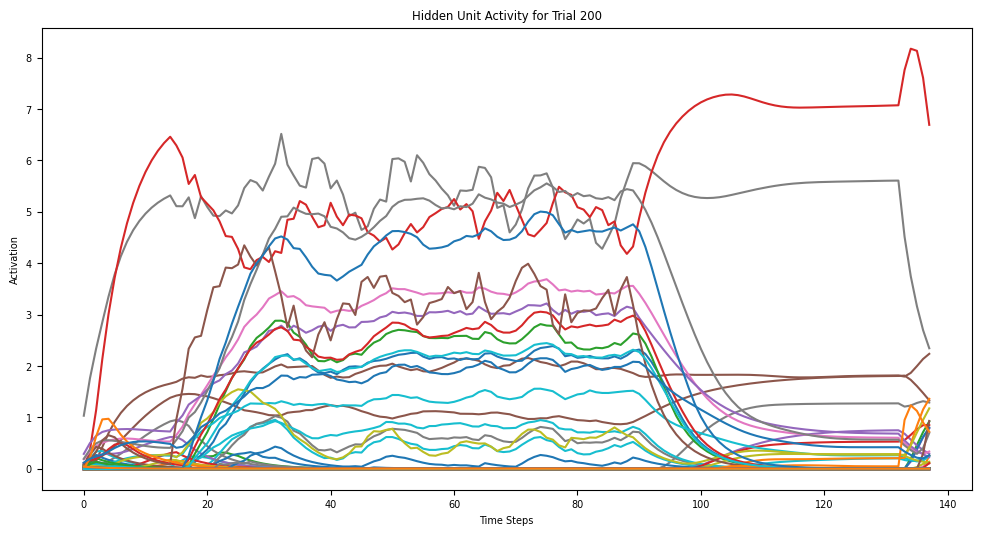

In [16]:
trial_number = 199  # Select a specific trial to visualize
rnn_activity = activity_dict[trial_number]  # Get the activity for the selected trial

plt.figure(figsize=(12, 6))
for i in range(rnn_activity.shape[1]):  # Plot each hidden unit's activity
    plt.plot(rnn_activity[:, i])
plt.xlabel('Time Steps')
plt.ylabel('Activation')
plt.title(f'Hidden Unit Activity for Trial {trial_number + 1}')
plt.show()